<font size="+4">Alexa, how many people have your name?</font>

***Work in Progress***

# Introduction

## What you can learn

## Datasets

### Amazon Alexa
- **Release dates [[1](#references)]:**</br>
The release dates of Amazon Alexa for the different countries are covered by a table on the Wikipedia. I manually looked up the dates for the individual countries.

### Baby Names
- **England and Wales [[2](#references)] [[3](#references)]:**<br>
The GB Office for National Statistics provided their data in two different subsets: The first dataset covers the years 1907 to 1994, but contains only the top 100 names and only their sex and rank, not their count. The second dataset covers from 1996 to 2018 is more complete, covering much more names (with count >= 3) and provides gender, rank and counts. I wasn't able to identify datasets for the missing year 1995.

- **United States [[4](#references)]:**<br>
This dataset provided by the US Social Security Administration (SSA) seems quite complete: It contains information on name, sex, count and rank covers for every years from 1880 to 2018. The fact that it contains names with single occurcance (count=1) indicates, that *all* names are included.

- **Switzerland [[5](#references)]:**<br>
Provided by the Swizz Buro for Statistics, this dataset covers counts, ranks and sex for all names with at least 6 occurances in the year 2018, and reaches back to the year 1998. 

- **New Zealand [[6](#references)]:**<br>
Covering the years from 1900 to 2019, this dataset by the Department of Internal Affairs and includes all names with at least 10 occurances together with their sex and count from 1900 to 2019. 

- TODO CANADA **Austria [[7](#references)]:**<br>
This dataset from Open Data Austria contains count, year and sex for every names. Sadly it goes back only to 2010 and the latest entries are from 2016, so it turned out to be not very useful right now.

**Other possible Sources:**
- https://www.data.gv.at/katalog/dataset/stat_vornamen
- https://data.sa.gov.au/data/Referencesdataset/popular-baby-names
- https://open.alberta.ca/opendata/frequency-and-ranking-of-baby-names-by-year-and-gender

**Assets:**
- https://commons.wikimedia.org/wiki/File:Amazon_Alexa_logo.svg
- https://commons.wikimedia.org/wiki/File:Amazon_Alexa_blue_logo.svg
- https://commons.wikimedia.org/wiki/File:Amazon_echo.png
- https://www.piqsels.com/sv/search?q=amazon+echo
- https://www.piqsels.com/sv/public-domain-photo-jwihl

# Setup

## Imports

In [1]:
# Default
from pathlib import Path
from zipfile import ZipFile
import io
import urllib
import datetime
import sys
import platform
import psutil

# Extra
import pandas as pd
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt, font_manager
from PIL import Image, ImageDraw, ImageFont

## System information

Sometimes useful for reproducability:

In [2]:
print("---- System information ----")
print(f"OS: {platform.uname().system}, {platform.uname().release}")
print(f"Platform: {platform.uname().machine}")
print("Logical cores:", psutil.cpu_count(logical=True))
print(f"Max Frequency: {psutil.cpu_freq().max:.0f} Mhz")
print(f"Total Memory: {psutil.virtual_memory().total / 1024 / 1024 / 1024:.2F} GB")

print("\n---- Python information ----")
print(f"python: {sys.version.split(' ')[0]}")
print(f"psutil: {psutil.__version__}")
print(f"pandas: {pd.__version__}")
print(f"seaborn: {sns.__version__}")
print(f"matplotlib: {matplotlib.__version__}")

---- System information ----
OS: Linux, 5.3.0-29-generic
Platform: x86_64
Logical cores: 8
Max Frequency: 4000 Mhz
Total Memory: 31.13 GB

---- Python information ----
python: 3.7.3
psutil: 5.6.7
pandas: 0.25.3
seaborn: 0.9.0
matplotlib: 3.1.2


## Configuration

In [3]:
# Styling
pd.plotting.register_matplotlib_converters()
sns.set(style="darkgrid")


# Datasets
DATA_PATH = Path(".") / "data" / "alexa"
ASSETS_PATH = Path(".") / "assets" / "alexa"

DATA_PATH.mkdir(parents=True, exist_ok=True)
ASSETS_PATH.mkdir(parents=True, exist_ok=True)

DATASETS = {
    "US": {
        "description": "United States",
        "url": "https://www.ssa.gov/oact/babynames/names.zip",
        "filename": "names_us.zip",
        "release": datetime.date(2015, 6, 28),
    },
    "CA": {
        "description": "Canada (AB)",
        "url_prefix": "",
        "url": [
            "https://open.alberta.ca/dataset/11245675-b047-49fc-8bd1-cc2ce8314a6d/resource/e8aac308-c754-484c-b446-0c57ed0e8d37/download/baby-names-frequency.xlsx"
        ],
        "filename": "names_ca.zip",
        "release": datetime.date(2017, 12, 5),
    },
    "NZ": {
        "description": "New Zealand",
        "url_prefix": "",
        "url": [
            "https://catalogue.data.govt.nz/dataset/01ee87cd-ecf8-44a1-ad33-b376a689e597/resource/0b0b326c-d720-480f-8f86-bf2d221c7d3f/download/baby-names-2020-1-6.csv"
        ],
        "filename": "names_nz.zip",
        "release": datetime.date(2018, 2, 1),
    },
    "CH": {
        "description": "Switzerland",
        "url_prefix": "",
        "url": [
            "https://www.bfs.admin.ch/bfsstatic/dam/assets/9127668/master",
            "https://www.bfs.admin.ch/bfsstatic/dam/assets/9127688/master",
        ],
        "filename": "names_ch.zip",
        "release": datetime.date(2020, 1, 1),
    },
    "EN, WLS": {
        "description": "England & Wales",
        "url_prefix": "https://www.ons.gov.uk/file?uri=%2fpeoplepopulationandcommunity%2fbirthsdeathsandmarriages%2flivebirths%2fdatasets%2fbabynamesenglandandwales",
        "url": [
            "top100babynameshistoricaldata%2f19041994/historicname_tcm77-254032.xls",
            "babynamesstatisticsboys%2f1996/1996boys_tcm77-254026.xls",
            "babynamesstatisticsboys%2f1997/1997boys_tcm77-254022.xls",
            "babynamesstatisticsboys%2f1998/1998boys_tcm77-254018.xls",
            "babynamesstatisticsboys%2f1999/1999boys_tcm77-254014.xls",
            "babynamesstatisticsboys%2f2000/2000boys_tcm77-254008.xls",
            "babynamesstatisticsboys%2f2001/2001boys_tcm77-254000.xls",
            "babynamesstatisticsboys%2f2002/2002boys_tcm77-253994.xls",
            "babynamesstatisticsboys%2f2003/2003boys_tcm77-253990.xls",
            "babynamesstatisticsboys%2f2004/2004boys_tcm77-253986.xls",
            "babynamesstatisticsboys%2f2005/2005boys_tcm77-253982.xls",
            "babynamesstatisticsboys%2f2006/2006boys_tcm77-253978.xls",
            "babynamesstatisticsboys%2f2007/2007boys_tcm77-253973.xls",
            "babynamesstatisticsboys%2f2008/2008boys_tcm77-253966.xls",
            "babynamesstatisticsboys%2f2009/2009boys_tcm77-253932.xls",
            "babynamesstatisticsboys%2f2010/2010boys_tcm77-253928.xls",
            "babynamesstatisticsboys%2f2011/2011boysbabynamesfinal_tcm77-276133.xls",
            "babynamesstatisticsboys%2f2012/2012boysbyareagorrsmonthwebtables_tcm77-323077.xls",
            "babynamesstatisticsboys%2f2013/2013boysbyareagorrsmonthwebtables_tcm77-374580.xls",
            "babynamesstatisticsboys%2f2014/2014boysbyareagorrsmonthwebtables_tcm77-413738.xls",
            "babynamesstatisticsboys%2f2015/2015boysnamesfinal.xls",
            "babynamesstatisticsboys%2f2016/2016boysnames.xls",
            "babynamesstatisticsboys%2f2017/2017boysnames.xls",
            "babynamesstatisticsboys%2f2018/2018boysnames.xls",
            "babynamesstatisticsgirls%2f1996/1996girls_tcm77-254024.xls",
            "babynamesstatisticsgirls%2f1997/1997girls_tcm77-254020.xls",
            "babynamesstatisticsgirls%2f1998/1998girls_tcm77-254016.xls",
            "babynamesstatisticsgirls%2f1999/1999girls_tcm77-254010.xls",
            "babynamesstatisticsgirls%2f2000/2000girls_tcm77-254006.xls",
            "babynamesstatisticsgirls%2f2001/2001girls_tcm77-253998.xls",
            "babynamesstatisticsgirls%2f2002/2002girls_tcm77-253992.xls",
            "babynamesstatisticsgirls%2f2003/2003girls_tcm77-253988.xls",
            "babynamesstatisticsgirls%2f2004/2004girls_tcm77-253984.xls",
            "babynamesstatisticsgirls%2f2005/2005girls_tcm77-253980.xls",
            "babynamesstatisticsgirls%2f2006/2006girls_tcm77-253976.xls",
            "babynamesstatisticsgirls%2f2007/2007girls_tcm77-253971.xls",
            "babynamesstatisticsgirls%2f2008/2008girls_tcm77-253964.xls",
            "babynamesstatisticsgirls%2f2009/2009girls_tcm77-253940.xls",
            "babynamesstatisticsgirls%2f2010/2010girls_tcm77-253930.xls",
            "babynamesstatisticsgirls%2f2011/2011girlsbabynamesfinal_tcm77-276135.xls",
            "babynamesstatisticsgirls%2f2012/2012girlsbyareagorrsmonthwebtables_tcm77-323080.xls",
            "babynamesstatisticsgirls%2f2013/2013girlsbyareagorrsmonthwebtables_tcm77-374588.xls",
            "babynamesstatisticsgirls%2f2014/2014girlsbyareagorrsmonthwebtables_tcm77-413741.xls",
            "babynamesstatisticsgirls%2f2015/2015girlsnamesfinal.xls",
            "babynamesstatisticsgirls%2f2016/2016girlsnames.xls",
            "babynamesstatisticsgirls%2f2017/2017girlsnames.xls",
            "babynamesstatisticsgirls%2f2018/2018girlsnames.xls",
        ],
        "filename": "names_en_wls.zip",
        "release": datetime.date(2016, 9, 28),
    },
}

# Preparation

## Download Datasets

In [4]:
def download_datasets(overwrite=False):
    # Download and store files
    for name, desc in DATASETS.items():
        print(f"Downloading {name}-dataset:")
        target_file = DATA_PATH / desc["filename"]

        if target_file.exists() and not overwrite:
            print(f"Skipped download: {target_file} already exists.")
            continue

        # Handling multiple files...
        if isinstance(desc["url"], list):
            with ZipFile(target_file, "w") as zipObj:
                for idx, url in enumerate(desc["url"]):
                    url = desc["url_prefix"] + url
                    print(f"Get {'...' + url[-90:] if len(url) > 90 else url}")
                    req = urllib.request.Request(
                        url, headers={"User-Agent": "Mozilla/5.0"}
                    )
                    resp = urllib.request.urlopen(req)
                    stream = io.BytesIO()
                    stream.write(resp.read())
                    stream.seek(0)
                    if resp.info().get_filename():
                        fn = resp.info().get_filename()
                    else:
                        fn = url.split("/")[-1]
                    zipObj.writestr(fn, stream.getvalue())
        # Handling already zipped file...
        else:
            print(f"Get {desc['url'][-80:]}")
            urllib.request.urlretrieve(desc["url"], target_file)

        print("Done.\n")

In [5]:
%%time

download_datasets(overwrite=False)

Get https://www.ssa.gov/oact/babynames/names.zip
Done.

Get ...ce8314a6d/resource/e8aac308-c754-484c-b446-0c57ed0e8d37/download/baby-names-frequency.xlsx
Done.

Get ...376a689e597/resource/0b0b326c-d720-480f-8f86-bf2d221c7d3f/download/baby-names-2020-1-6.csv
Done.

Get https://www.bfs.admin.ch/bfsstatic/dam/assets/9127668/master
Get https://www.bfs.admin.ch/bfsstatic/dam/assets/9127688/master
Done.

Get ...namesenglandandwalestop100babynameshistoricaldata%2f19041994/historicname_tcm77-254032.xls
Get ...atasets%2fbabynamesenglandandwalesbabynamesstatisticsboys%2f1996/1996boys_tcm77-254026.xls
Get ...atasets%2fbabynamesenglandandwalesbabynamesstatisticsboys%2f1997/1997boys_tcm77-254022.xls
Get ...atasets%2fbabynamesenglandandwalesbabynamesstatisticsboys%2f1998/1998boys_tcm77-254018.xls
Get ...atasets%2fbabynamesenglandandwalesbabynamesstatisticsboys%2f1999/1999boys_tcm77-254014.xls
Get ...atasets%2fbabynamesenglandandwalesbabynamesstatisticsboys%2f2000/2000boys_tcm77-254008.xls
Get ...at

**Let's check, how much space the (zipped) data needs on our Harddrive:**

In [6]:
data_size = sum(f.stat().st_size for f in DATA_PATH.glob("**/*") if f.is_file())
print(f"Size of all data files (/{DATA_PATH}/*): {data_size / 1024 / 1024:.2f} MB")

Size of all data files (/data/alexa/*): 60.24 MB


## Prepare Dataset

Helper functions for simple loading datasets into pandas DataFrame:

In [7]:
def gen_dataset_us():
    """Generator yielding on year from US dataset.

    Yields:
        {pd.DataFrame} -- Dataframe containing names of one year

    """
    file_path = DATA_PATH / DATASETS["US"]["filename"]
    with ZipFile(file_path, "r") as zip:
        files = [f for f in zip.namelist() if f.endswith(".txt")]
        for f in files:
            df = pd.read_csv(zip.open(f), names=["Name", "Sex", "Count"])
            df["Year"] = pd.to_datetime(int(f[3:7]), format="%Y")
            df["Dataset"] = "US"
            df["Rank"] = df.groupby("Sex")["Count"].rank(method="max", ascending=False)
            yield df

In [8]:
def gen_dataset_nz():
    """Generator yielding on year from NZ dataset.

    Yields:
        {pd.DataFrame} -- Dataframe containing names of one year

    """
    file_path = DATA_PATH / DATASETS["NZ"]["filename"]
    with ZipFile(file_path, "r") as zip:
        files = [f for f in zip.namelist() if f.endswith(".csv")]
        for f in files:
            df = pd.read_csv(zip.open(f), encoding="ISO-8859-2")
            df["Year"] = pd.to_datetime(df["Year"], format="%Y")
            df["Dataset"] = "NZ"
            df["Rank"] = df.groupby(["Year", "Sex"])["Count"].rank(
                method="max", ascending=False
            )
            yield df

In [9]:
def gen_dataset_ch():
    """Generator yielding on year from CH dataset.

    Yields:
        {pd.DataFrame} -- Dataframe containing names multiple years and one gender

    """
    file_path = DATA_PATH / DATASETS["CH"]["filename"]
    with ZipFile(file_path, "r") as zip:
        files = [f for f in zip.namelist() if f.endswith(".xlsx")]
        for fn in files:
            df = pd.read_excel(zip.open(fn), sheet_name=0, header=[2, 3], skipfooter=5)

            # Rename columns
            col_mapping = {
                "Vornamen": "Name",
                "Unnamed: 0_level_1": "Name",
                "Unnamed: 0_level_0": "Name",
                "Rang": "Rank",
                "Anzahl": "Count",
            }
            df = df.rename(columns=col_mapping, level=0).rename(
                columns=col_mapping, level=1
            )

            # Read columns year by year
            year_cols = list(df.columns.levels[0])
            year_cols.remove("Name")

            for col in year_cols:
                df_year = df[["Name", col]].copy()
                df_year.columns = df_year.columns.droplevel(level=0)
                df_year["Year"] = pd.to_datetime(col, format="%Y")
                df_year["Dataset"] = "CH"
                if fn == "su-d-01.04.00.01.xlsx":
                    df_year["Sex"] = "F"
                else:
                    df_year["Sex"] = "M"

                yield df_year

In [10]:
def gen_dataset_ca():
    """Generator yielding on year from CA dataset.

    Yields:
        {pd.DataFrame} -- Dataframe containing names multiple years and one gender

    """
    file_path = DATA_PATH / DATASETS["CA"]["filename"]
    with ZipFile(file_path, "r") as zip:
        files = [f for f in zip.namelist() if f.endswith(".xlsx")]
        for fn in files:
            df = pd.read_excel(
                zip.open(fn),
                sheet_name=0,
                header=5,
                names=["Rank", "Name", "Count", "Sex", "Year"],
            )
            df["Year"] = pd.to_datetime(df["Year"], format="%Y")
            df["Sex"] = df["Sex"].replace({"Boy": "M", "Girl": "F"})
            df["Dataset"] = "CA"
            yield df

In [11]:
def gen_dataset_en_wls():
    """Generator yielding on year from GB dataset.

    Yields:
        {pd.DataFrame} -- Dataframe containing names of one year

    """

    def _map_year_sheet(year):
        if year == 1996:
            return 3
        elif year <= 2010:
            return 6
        else:
            return 8

    def _map_year_header(year):
        if year <= 2008:
            return 5
        elif year <= 2016:
            return 4
        else:
            return 5

    def _map_year_cols(year):
        if year <= 2016:
            return [1, 2, 3]
        else:
            return [0, 1, 2]

    def _load_historic(zip, fn, sheet):
        df = pd.read_excel(zip.open(fn), sheet_name=sheet, header=3, skipfooter=2)
        # Drop empty first row
        df = df.dropna()
        # Unpivot
        df = df.melt(id_vars=["RANK"], value_vars=[1904])
        # Rename Columns
        df.columns = ["Rank", "Year", "Name"]
        # Normalize Casing
        df["Name"] = df["Name"].str.title().str.strip()
        # Cast Datatypes
        df["Rank"] = df["Rank"].astype(int)
        df["Year"] = pd.to_datetime(df["Year"], format="%Y")
        # Add Gender and Country information
        df["Sex"] = "M" if sheet == "Boys" else "F"
        df["Dataset"] = "EN, WLS"
        return df

    def _load_recent(zip, fn):
        year = int(fn[:4])
        df = pd.read_excel(
            zip.open(fn),
            sheet_name=_map_year_sheet(year),
            header=_map_year_header(year),
            usecols=_map_year_cols(year),
            names=["Rank", "Name", "Count"],
        )
        # Number of footer rows in xls varies, so sometimes we get empty rows
        df = df.dropna()
        # Normalize Casing
        df["Name"] = df["Name"].str.title().str.strip()
        # Cast Datatypes
        df[["Rank", "Count"]] = df[["Rank", "Count"]].astype(int)
        # Add year and gender (from filename), and country information
        df["Year"] = pd.to_datetime(year, format="%Y")
        df["Sex"] = "M" if "boys" in fn else "F"
        df["Dataset"] = "EN, WLS"
        return df

    file_path = DATA_PATH / DATASETS["EN, WLS"]["filename"]
    with ZipFile(file_path, "r") as zip:
        files = [fn for fn in zip.namelist() if fn.endswith(".xls")]
        for fn in files:
            if fn.startswith("historicname"):
                yield _load_historic(zip, fn, "Boys")
                yield _load_historic(zip, fn, "Girls")
            if fn[:4].isdigit():
                yield _load_recent(zip, fn)

In [12]:
def load_datasets(names):
    """Helper function to load datasets into single dataframe.

    This also brings all datasets into the same form.

    Arguments:
        name {list} -- List of dataset short names, according to DATASETS

    Returns:
        {pd.DataFrame} -- All datasets in a single dataframe

    """
    list_dfs = []

    # Load individual Datasets
    if "US" in names or "all" in names:
        list_dfs.extend(gen_dataset_us())

    if "EN, WLS" in names or "all" in names:
        list_dfs.extend(gen_dataset_en_wls())

    if "CH" in names or "all" in names:
        list_dfs.extend(gen_dataset_ch())

    if "NZ" in names or "all" in names:
        list_dfs.extend(gen_dataset_nz())

    if "CA" in names or "all" in names:
        list_dfs.extend(gen_dataset_ca())

    # Merge list of dataframes into single dataframe
    df_all = pd.concat(list_dfs, axis=0, ignore_index=True, sort=False)

    return df_all

**Actually loading the data:**

In [13]:
%%time

df = load_datasets(["all"])
display(df.head())
display(df.tail())

,Name,Sex,Count,Year,Dataset,Rank
0,Mary,F,7065.0,1880-01-01,US,1.0
1,Anna,F,2604.0,1880-01-01,US,2.0
2,Emma,F,2003.0,1880-01-01,US,3.0
3,Elizabeth,F,1939.0,1880-01-01,US,4.0
4,Minnie,F,1746.0,1880-01-01,US,5.0


,Name,Sex,Count,Year,Dataset,Rank
2689961,Élize,F,1.0,2018-01-01,CA,2175.0
2689962,Éloïse,F,1.0,2018-01-01,CA,2175.0
2689963,Émily,F,1.0,2018-01-01,CA,2175.0
2689964,Éowyn,F,1.0,2018-01-01,CA,2175.0
2689965,Ñulia,F,1.0,2018-01-01,CA,2175.0


CPU times: user 53.4 s, sys: 239 ms, total: 53.6 s
Wall time: 53.7 s


## Quick Sanity Checks

**Do ranks and counts make sense?**

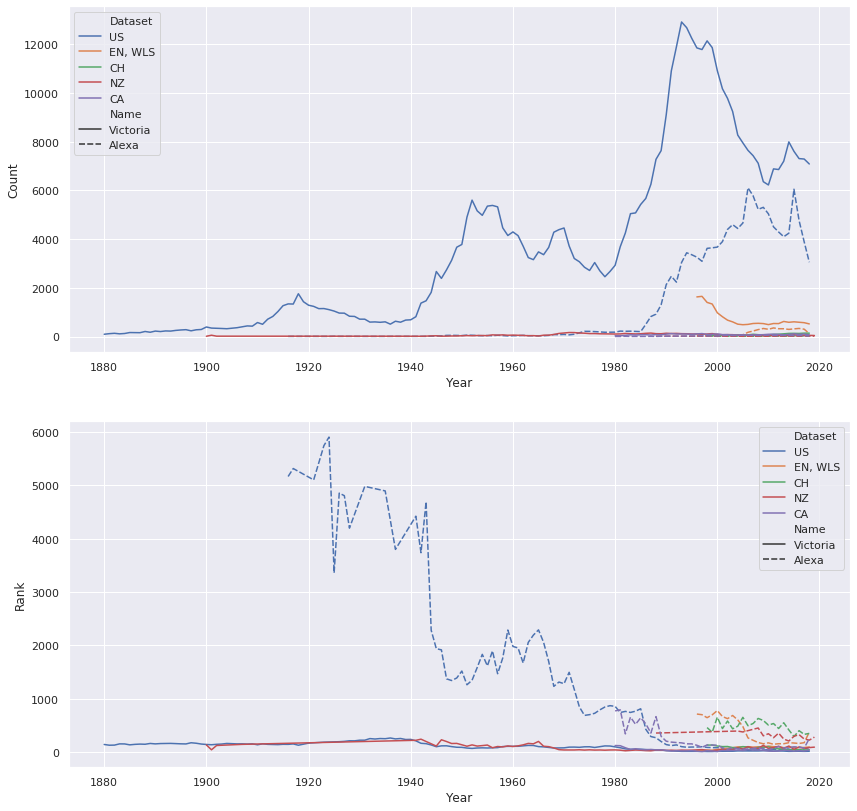

In [14]:
df_temp = df[(df["Name"].isin(["Alexa", "Victoria"])) & (df["Sex"] == "F")]

fig, ax = plt.subplots(2, 1, figsize=(14, 14))
sns.lineplot(x="Year", y="Count", hue="Dataset", style="Name", data=df_temp, ax=ax[0])
sns.lineplot(x="Year", y="Rank", hue="Dataset", style="Name", data=df_temp, ax=ax[1]);

## Filter dataset

**Limit to Name "Alexa"** (also drop "Name" column, as the data now only contains a single name)

In [15]:
df_alexa = df[(df["Name"] == "Alexa") & (df["Sex"] == "F")]

# Also drop "Name", as everything is "Alexa" now:
df_alexa = df_alexa.drop(columns="Name")

df_alexa.head()

,Sex,Count,Year,Dataset,Rank
133506,F,5.0,1916-01-01,US,5162.0
143378,F,5.0,1917-01-01,US,5311.0
184682,F,6.0,1921-01-01,US,5098.0
206801,F,5.0,1923-01-01,US,5739.0
217549,F,5.0,1924-01-01,US,5899.0


**Limit to years since 1997**  (dataset of some countries don't reach further back)

In [16]:
df_alexa = df_alexa[(df_alexa["Year"] >= "1997-01-01")]
df_alexa.head()

,Sex,Count,Year,Dataset,Rank
1249491,F,3090.0,1997-01-01,US,106.0
1276448,F,3622.0,1998-01-01,US,93.0
1304346,F,3644.0,1999-01-01,US,89.0
1332896,F,3674.0,2000-01-01,US,87.0
1362659,F,3898.0,2001-01-01,US,78.0


## Sort Datasets by Amazon Alexa's Release Date

In [17]:
dataset_temp = sorted(DATASETS.items(), key=lambda kv: kv[1]["release"])
dataset_sorted = [d[0] for d in dataset_temp]
datasets_count = len(dataset_sorted)

print(f"Sorted datasets: {dataset_sorted}")

Sorted datasets: ['US', 'EN, WLS', 'CA', 'NZ', 'CH']


# Visualization

## Quick and dirty version

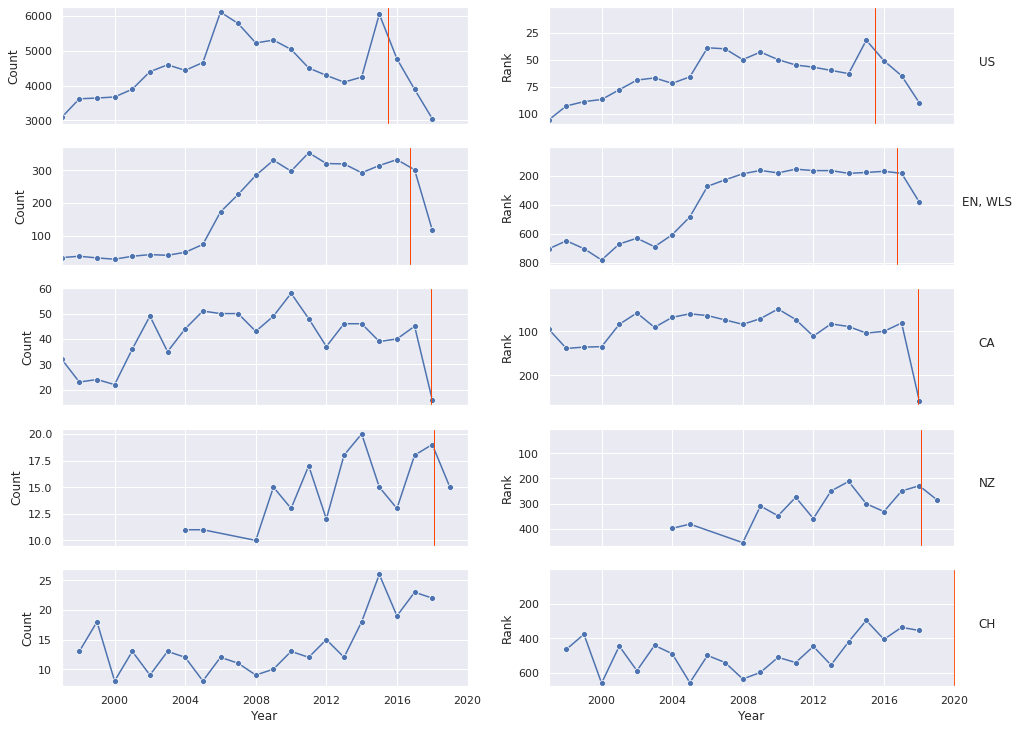

In [18]:
fig, ax = plt.subplots(
    datasets_count, 2, figsize=(16, datasets_count * 2.5), sharex=True
)

for idx, dataset in enumerate(dataset_sorted):
    df_alexa_dataset = df_alexa[df_alexa["Dataset"] == dataset]
    sns.lineplot(x="Year", y="Count", data=df_alexa_dataset, ax=ax[idx][0], marker="o")

    sns.lineplot(
        x="Year", y="Rank", data=df_alexa_dataset, ax=ax[idx][1], marker="o"
    ).set_title(dataset, x=1.08, y=0.45)
    ax[idx][1].set_ylim(1,)
    ax[idx][1].invert_yaxis()
    ax[idx][1].set_xlim("1997-01-01", "2020-01-01")

    for ax_i in range(0, 2):
        if DATASETS[dataset]["release"]:
            ax[idx][ax_i].axvline(
                x=DATASETS[dataset]["release"], color="orangered", linewidth=1
            )
        else:
            ax[idx][ax_i].text(
                1,
                0.5,
                "Not yet released",
                color="orangered",
                horizontalalignment="center",
                verticalalignment="center",
                rotation=90,
                transform=ax[idx][ax_i].transAxes,
            )

## Final Version

In [19]:
ALEXA_BLUE = "#5fcaf4"
BG_COLOR = "#2c2f38"
CANVAS_COLOR = "#202124"

In [20]:
# Download "Assistant" Font, which is close to the Amazon's Ember font but free
font_file = ASSETS_PATH / "assistant.ttf"
font_url = "https://github.com/hafontia/Assistant/blob/master/Fonts/TTF/Assistant-Regular.ttf?raw=true"

if not font_file.exists():
    urllib.request.urlretrieve(font_url, font_file)
    print(f"Downloaded {font_file},")

In [21]:
def add_text(ax):
    y_adjust = 0.01
    x_adjust = 0

    ax.grid(False)

    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax.patch.set_facecolor(CANVAS_COLOR)
    alexa_font_prop = font_manager.FontProperties(
        fname=str(font_file.resolve()), size=72
    )
    alexa_font_prop_small = font_manager.FontProperties(
        fname=str(font_file.resolve()), size=42
    )
    alexa_font_prop_tiny = font_manager.FontProperties(
        fname=str(font_file.resolve()), size=12
    )
    ax.text(
        0 + x_adjust,
        1 + y_adjust,
        "Hey            ,",
        # transform=plt.gcf().transFigure,
        fontproperties=alexa_font_prop,
        fontdict={
            "fontstretch": "condensed",
            "color": "white",
            "verticalalignment": "top",
        },
    )
    ax.text(
        0 + x_adjust,
        1 + y_adjust,
        "         Alexa",
        # transform=plt.gcf().transFigure,
        fontproperties=alexa_font_prop,
        fontdict={
            "fontstretch": "condensed",
            "color": ALEXA_BLUE,
            "verticalalignment": "top",
        },
    )
    ax.text(
        0 + x_adjust,
        1 + y_adjust - 0.18,
        "how many babys\nare named after you?",
        # transform=plt.gcf().transFigure,
        fontproperties=alexa_font_prop_small,
        fontdict={
            "fontstretch": "condensed",
            "color": "white",
            "verticalalignment": "top",
        },
        linespacing=1.4,
    )

    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    return

In [22]:
def plot_dataset(dataset, ax, plot_no):
    df_alexa_dataset = df_alexa[df_alexa["Dataset"] == dataset]

    ax.plot(
        df_alexa_dataset["Year"], df_alexa_dataset["Rank"], color="white", marker="o"
    )
    ax.patch.set_facecolor(BG_COLOR)

    if dataset == "CH":
        white_line = plt.Line2D(
            (0, 1), (0, 0), color="white", marker="o", label="Rank of baby name 'Alexa'"
        )
        blue_line = plt.Line2D(
            (0, 1), (0, 0), color=ALEXA_BLUE, label="Release of Amazon Alexa"
        )

    # Axes
    ax.set_xlim("1998-01-01", "2020-01-01")
    ax.xaxis.tick_top()
    ax.set_xlabel("")

    ax.set_ylim(0, df_alexa_dataset["Rank"].max() * 1.1)
    ax.invert_yaxis()
    h = ax.set_ylabel(
        f"{DATASETS[dataset]['description']}",
        color="#888888",
        labelpad=10,
        size=12,
        verticalalignment="top",
        horizontalalignment="left",
        weight="bold",
    )
    h.set_rotation(0)
    ax.get_yaxis().set_label_coords(0.01, 0.95)

    # Grid lines
    ax.grid(b=True, which="major", color="#3c4043", linestyle="-")
    ax.spines["bottom"].set_color(BG_COLOR)
    ax.spines["left"].set_color("white")
    ax.spines["top"].set_color("white")
    ax.spines["right"].set_color(BG_COLOR)

    # Texts
    ax.tick_params(colors="white")

    if DATASETS[dataset]["release"] < datetime.date(2020, 1, 1):
        ax.axvline(x=DATASETS[dataset]["release"], color=ALEXA_BLUE, linewidth=1.3)
        text = DATASETS[dataset]["release"]
    else:
        text = "not yet"

    ax.annotate(
        s=text,
        size=10,
        xy=(DATASETS[dataset]["release"], max(df_alexa_dataset["Rank"])),
        xytext=(-5, -5),
        color=ALEXA_BLUE,
        horizontalalignment="right",
        verticalalignment="bottom",
        textcoords="offset points",
    )

    # Hide x-ticks for all but first plot
    if plot_no[0] != 0:
        ax.get_xaxis().set_ticklabels([])
        ax.tick_params(axis="x", colors=CANVAS_COLOR)

    # Plot legend after last plot
    if plot_no[0] == plot_no[1] - 1:
        legend = plt.legend(
            handles=[white_line, blue_line],
            loc="upper center",
            fancybox=True,
            facecolor=BG_COLOR,
            edgecolor="#3c4043",
            ncol=2,
            bbox_to_anchor=(0.5, -0.2),
        )
        plt.setp(legend.get_texts(), color="w")

    return ax

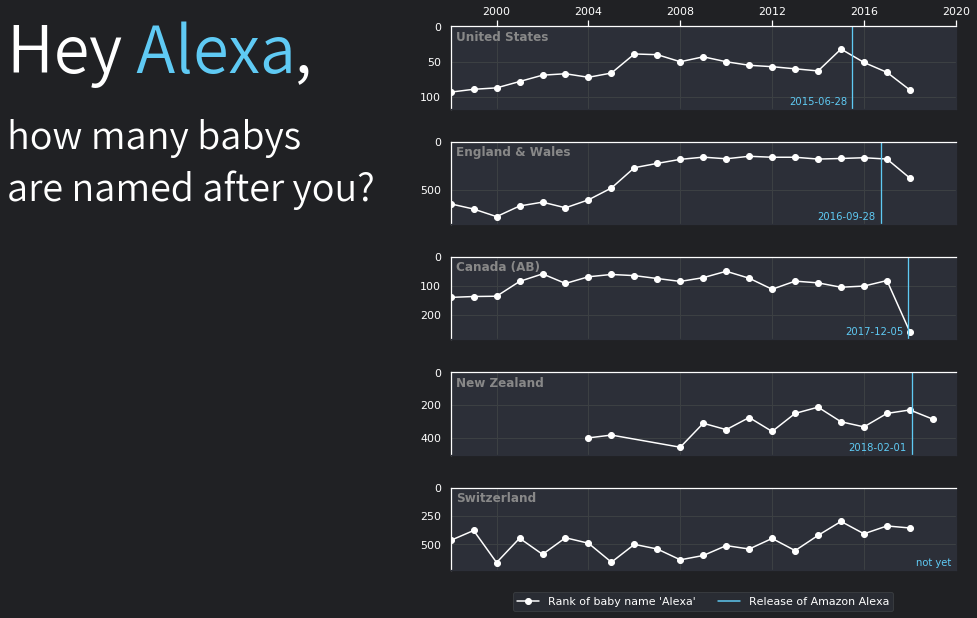

In [23]:
fig = plt.figure(figsize=(17, 10))
fig.patch.set_facecolor(CANVAS_COLOR)

# Plot main plot
gs = fig.add_gridspec(datasets_count, 13, hspace=0.4)

ax_text = fig.add_subplot(gs[:, :6])
add_text(ax_text)

for idx, dataset in enumerate(dataset_sorted):
    ax_temp = fig.add_subplot(gs[idx, 6:])
    plot_dataset(dataset, ax_temp, plot_no=(idx, len(dataset_sorted)))

In [24]:
def add_margin(pil_img, top, right, bottom, left, color):
    width, height = pil_img.size
    new_width = width + right + left
    new_height = height + top + bottom
    result = Image.new(pil_img.mode, (new_width, new_height), color)
    result.paste(pil_img, (left, top))
    return result

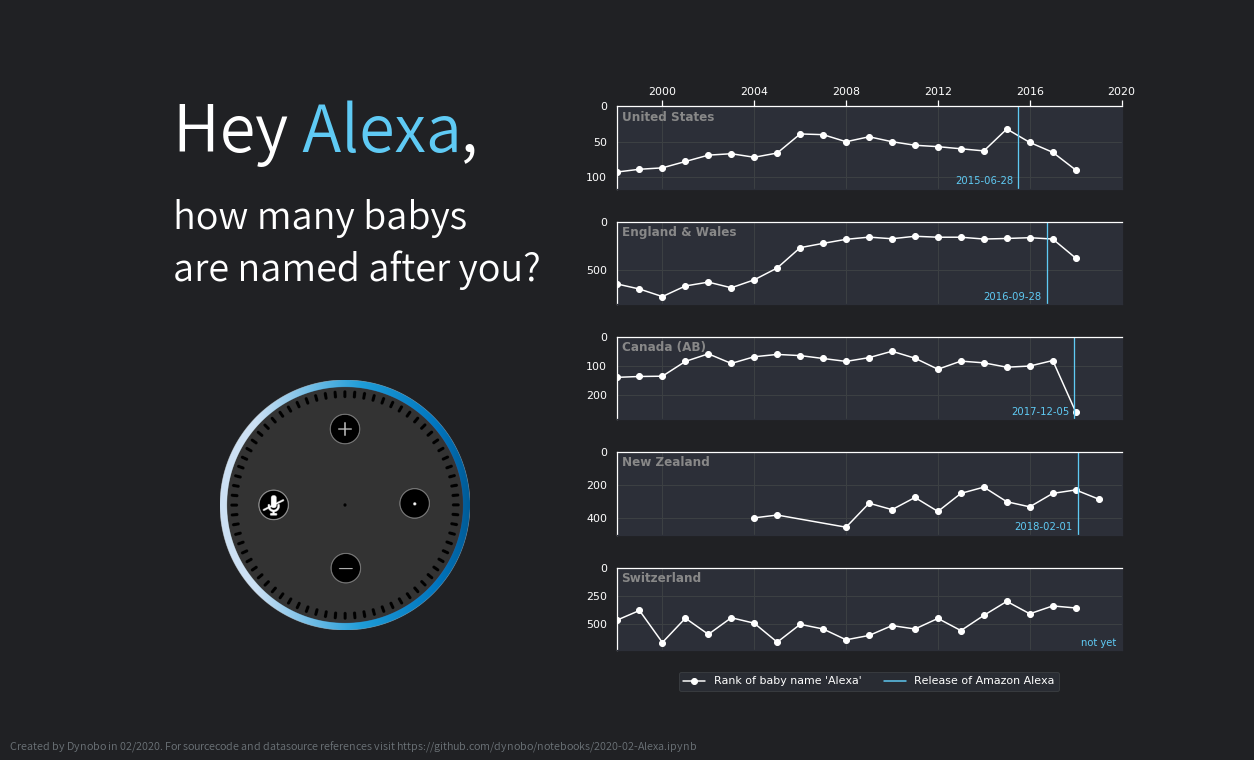

In [28]:
# Add padding
buf = io.BytesIO()
fig.savefig(buf, format="png", facecolor=CANVAS_COLOR)
buf.seek(0)
im = Image.open(buf)
im = add_margin(im, 20, 10, 20, 20, CANVAS_COLOR)

# Add text
draw = ImageDraw.Draw(im)
font = ImageFont.truetype(str(font_file.resolve()), size=12)
draw.text(
    (10, im.size[1] - 22),
    "Created by Dynobo in 02/2020. For sourcecode and datasource references visit https://github.com/dynobo/notebooks/2020-02-Alexa.ipynb",
    fill="#6C7378",
    font=font,
)

# Add device image
img_echo_png = Image.open("/home/jovyan/notebooks/assets/alexa/echo_200.png")
img_echo = Image.new("RGBA", img_echo_png.size, CANVAS_COLOR)
img_echo.paste(img_echo_png, (0, 0), img_echo_png)
im.paste(img_echo, (220, 380))

# Show
display(im)
buf.close()

<a name="references"></a>

# References

[1] Wikipedia contributors (2019): **Amazon Alexa**. In *Wikipedia - The Free Encyclopedia*. Retrieved Dec 28, 2019, from <https://en.wikipedia.org/w/index.php?title=Amazon_Alexa&oldid=932280905>

[2] Office for National Statistics (2019): **Baby names in England and Wales: 1996-2018**. Retrieved Dec 28, 2019, from <https://www.ons.gov.uk/peoplepopulationandcommunity/birthsdeathsandmarriages/livebirths/datasets/babynamesenglandandwalesbabynamesstatisticsgirls> and <https://www.ons.gov.uk/peoplepopulationandcommunity/birthsdeathsandmarriages/livebirths/datasets/babynamesenglandandwalesbabynamesstatisticsboys>

[3] Office for National Statistics (2019): **Top 100 baby names in England and Wales: 1907-1994**. Retrieved Dec 28, 2019, from <https://www.ons.gov.uk/peoplepopulationandcommunity/birthsdeathsandmarriages/livebirths/datasets/babynamesenglandandwalestop100babynameshistoricaldata>

[4] Social Security Administration (2019): **Baby Names from Social Security Card Applications - National Data**. Retrieved Jan 03, 2020, from https://catalog.data.gov/dataset/baby-names-from-social-security-card-applications-national-level-data

[5] Schweizer Eidgenossenschaft - Bundesamt für Statistik (2019): **Vornamen der Neugeborenen nach Sprachregion, 1998-2018**. Retrieved Jan 03, 2020, from <https://www.bfs.admin.ch/bfs/de/home/statistiken/bevoelkerung/geburten-todesfaelle/vornamen-neugeborene.assetdetail.9127688.html> and <https://www.bfs.admin.ch/bfs/de/home/statistiken/bevoelkerung/geburten-todesfaelle/vornamen-neugeborene.assetdetail.9127668.html>

[6] Department of Internal Affairs - New Zealand (2020): **Baby name counts over time**. Retrieved on Jan 10, 2020, from <https://catalogue.data.govt.nz/dataset/baby-name-popularity-over-time/resource/0b0b326c-d720-480f-8f86-bf2d221c7d3f>

[7] Statistik Austria (2018): **Katalog Vornamen**. Retrieved on Jan 10, 2020, from <https://www.data.gv.at/katalog/dataset/stat_vornamen>